In [1]:
# Mount Google Drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!7za -y x "/content/drive/MyDrive/Copy of New folder.zip"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 405159978 bytes (387 MiB)

Extracting archive: /content/drive/MyDrive/Copy of New folder.zip
 16% 4096 Open               48% 12288 Open               --
Path = /content/drive/MyDrive/Copy of New folder.zip
Type = zip
Physical Size = 405159978

  0%      1% 570 - New folder/color/Apple___Apple_ . 56372588d85___FREC_Scab 2940.JPG                                                                             

In [3]:
mydata= '/content/New folder/color'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Randomly zoom into images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill missing pixels using the nearest pixel
)


In [6]:
# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    mydata,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 25097 images belonging to 30 classes.


In [7]:
# import necessary Libraries for Manual Data Splitting
import os
import shutil

In [8]:
# Create train, test, and validation directories
split_dir = '/content/New folder/data_split/'
os.makedirs(split_dir + 'train', exist_ok=True)
os.makedirs(split_dir + 'test', exist_ok=True)
os.makedirs(split_dir + 'val', exist_ok=True)

In [9]:
# Define the percentage split
train_split = 0.7
test_split = 0.2
val_split = 0.1

In [10]:
# Iterate through the original data directory and move images to the split directories
for class_name in os.listdir(mydata):
    class_path = os.path.join(mydata, class_name)

    # Create corresponding directories in the split path
    os.makedirs(os.path.join(split_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'test', class_name), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'val', class_name), exist_ok=True)

    # List all images in the class directory
    class_images = os.listdir(class_path)
    num_images = len(class_images)

    # Calculate split indices
    train_end = int(train_split * num_images)
    test_end = train_end + int(test_split * num_images)

    # Move images to the appropriate split directory
    for i, image_name in enumerate(class_images):
        image_path = os.path.join(class_path, image_name)
        if i < train_end:
            split_path = os.path.join(split_dir, 'train', class_name)
        elif i < test_end:
            split_path = os.path.join(split_dir, 'test', class_name)
        else:
            split_path = os.path.join(split_dir, 'val', class_name)
        shutil.copy(image_path, os.path.join(split_path, image_name))


In [11]:
# Define new data directories for train, test, and validation

train_data_dir = os.path.join(split_dir, 'train')
test_data_dir = os.path.join(split_dir, 'test')
val_data_dir = os.path.join(split_dir, 'val')

In [12]:
# Data augmentation and preprocessing for validation data
val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1] for validation data
)

# Load and augment validation data
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for validation data
)

Found 2536 images belonging to 30 classes.


In [13]:
# Data augmentation and preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1] for test data
)

# Load and augment test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 5007 images belonging to 30 classes.


In [14]:
# import necessary Libraries to Load VGG16 pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [15]:
# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [22]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')  # 4 classes (Apple Scab, Black Rot, Apple Rust, Apple Healthy)
])

In [23]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# import laibary for TensorBoard Callback
from tensorflow.keras.callbacks import TensorBoard

In [27]:
from tensorflow.keras.callbacks import TensorBoard

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs")

# Train the model using the generators and the TensorBoard callback
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tensorboard_callback]  # Pass the TensorBoard callback here
)


Epoch 1/20
785/785 [==============================] - 386s 492ms/step - loss: 1.8166 - accuracy: 0.4179 - val_loss: 0.8564 - val_accuracy: 0.7413
Epoch 2/20
785/785 [==============================] - 385s 491ms/step - loss: 1.3741 - accuracy: 0.5315 - val_loss: 0.6293 - val_accuracy: 0.7772
Epoch 3/20
785/785 [==============================] - 385s 491ms/step - loss: 1.2665 - accuracy: 0.5676 - val_loss: 0.5563 - val_accuracy: 0.8072
Epoch 4/20
785/785 [==============================] - 383s 488ms/step - loss: 1.2052 - accuracy: 0.5864 - val_loss: 0.5331 - val_accuracy: 0.8190
Epoch 5/20
785/785 [==============================] - 384s 490ms/step - loss: 1.1714 - accuracy: 0.5991 - val_loss: 0.5203 - val_accuracy: 0.8391
Epoch 6/20
785/785 [==============================] - 395s 502ms/step - loss: 1.1496 - accuracy: 0.6036 - val_loss: 0.4734 - val_accuracy: 0.8442
Epoch 7/20
785/785 [==============================] - 386s 492ms/step - loss: 1.1100 - accuracy: 0.6146 - val_loss: 0.4442 -

In [29]:
# Save the model in h5 format
model.save('/content/drive/MyDrive/model.h5')
model.save('my_model.keras')

In [30]:
# import necessary Libraries for Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

157/157 [==============================] - 23s 143ms/step - loss: 0.3987 - accuracy: 0.8614
Test accuracy: 86.14%


In [32]:
predictions = model.predict(test_generator)  # Use test_generator here
predicted_labels = np.argmax(predictions, axis=1)


157/157 [==============================] - 19s 123ms/step


In [33]:
# True labels
true_labels = test_generator.labels  # Use test_generator.labels here

In [34]:
# Classification report
class_names = list(train_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.76      0.86       126
                                 Apple___Black_rot       0.98      0.98      0.98       124
                          Apple___Cedar_apple_rust       0.91      0.93      0.92        55
                                   Apple___healthy       0.85      0.99      0.92       185
          Cherry_(including_sour)___Powdery_mildew       0.97      0.95      0.96       198
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.71      0.78       102
                       Corn_(maize)___Common_rust_       0.97      1.00      0.98       185
               Corn_(maize)___Northern_Leaf_Blight       0.84      0.91      0.88       197
                            Corn_(maize)___healthy       0.99      0.98      0.

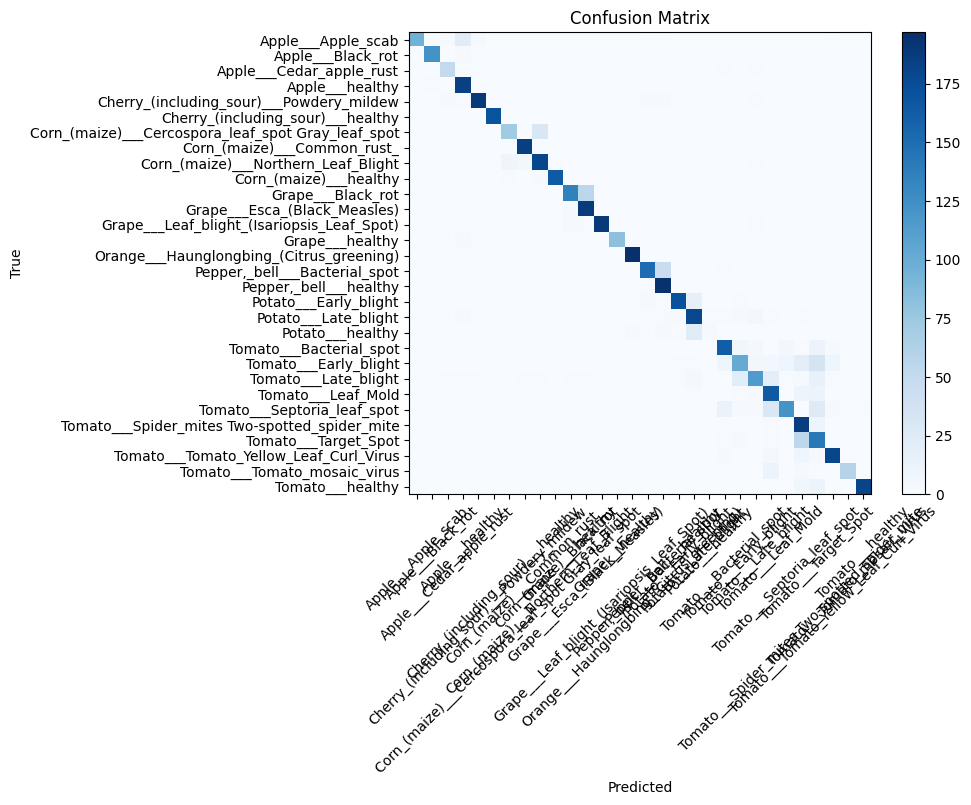

In [35]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
# Start TensorBoard in Colab
%load_ext tensorboard
%tensorboard --logdir ./logs

<IPython.core.display.Javascript object>

In [39]:
# definition of Function to test the model with input image
from tensorflow.keras.preprocessing import image

def test_single_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize

    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(image.load_img(image_path))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 78ms/step


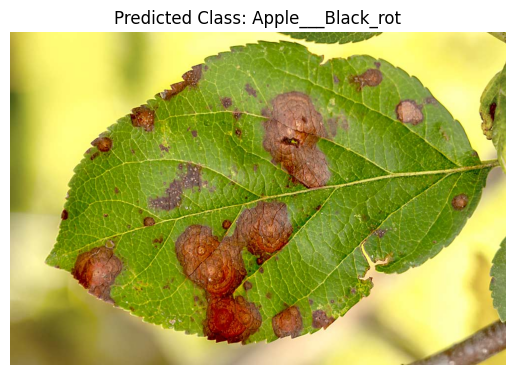

In [41]:
# Example usage:
test_single_image('/content/frogeye-1.jpg')

1/1 [==============================] - 0s 17ms/step


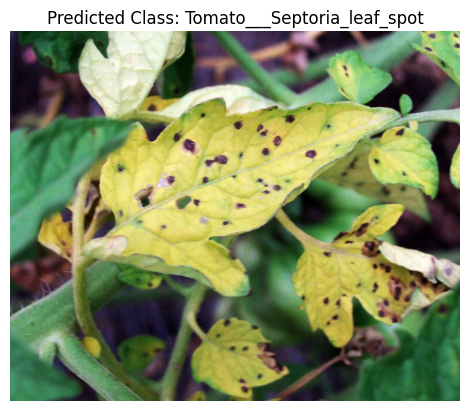

In [42]:
test_single_image('/content/septoria-spot-tomato-plant-ea2ab44d-e6f21d609dd04b2f96d96a33e98aab07.jpg')